# Project 1

Max Schrader

AEM 591

## Install the Required Packages

**Uncomment based on the package manager that you use**

In [1]:
# !pip install pint
# !pip install plotly
# !pip install prettytable
# !pip install numpy
# !pip install scipy
# !pip install --upgrade nbformat
# !pip install sympy
# !pip install control


# !conda commands (I think conda ships with numpy and scipy??)
# !conda install "jupyterlab>=3" "ipywidgets>=7.6" 
# !conda install -c conda-forge pint
# !conda install -c plotly plotly=5.3.1 
# !conda install -c conda-forge prettytable
# !conda install -c conda-forge control slycot

In [2]:
import math
from dataclasses import dataclass
from copy import deepcopy


import pint
import numpy as np
from scipy.integrate import solve_ivp, odeint
from scipy.signal import StateSpace, lsim
from prettytable import PrettyTable
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import control

pio.templates.default = "ggplot2"
pio.renderers.default = "jupyterlab"


## Helper Functions

In [3]:
ureg = pint.UnitRegistry()

In [4]:
def pretty_print(array: np.array, headers: list) -> None:
    x = PrettyTable()
    x.field_names = headers
    if len(headers) > 1 and len(array.shape) < 2:
        x.add_row(list(map(lambda x: round(x, 3), array)))
    else:
        for row in array:
            #             if len(array.shape) > 1:
            x.add_row(list(map(lambda x: round(x, 3), row)) if isinstance(
                row, (list, np.ndarray)) else [round(row, 3)])

#             x.add_row(round(row, 3))
    print(x)


### Constants

In [5]:
@dataclass
class Elevator:

    I_m = 700 * ureg.kilogram * ureg.meter ** 2
    K = 100 * ureg.newton * ureg.meter / ureg.ampere
    K_v = 100 * ureg.volt * ureg.second
    L = 0.4 * ureg.H
    m = 500 * ureg.kg
    g = 1 * ureg.gravity
    W = 300 * ureg.kilogram * 1 * ureg.gravity
    r_0 = 3 * ureg.meter
    delta_c = 0.05 * ureg.meter
    R_0 = 5 * ureg.ohm
    delta_r = 5 * ureg.ohm
    t_r = 3 * ureg.second
    x = 0 * ureg.meter

    def r_t(self, x=None, *args, **kwargs) -> pint.Quantity:
        x = x or self.x
        return ((self.delta_c * x / math.pi + self.r_0 ** 2) ** (1/2)).to('meter')

    def R_t(self, t: float) -> pint.Quantity:
        return (self.R_0 + self.delta_r * (1 - math.exp((-1 * t * ureg.second) / self.t_r))).to('ohm')

    @property
    def x_dot_bar(self, ) -> ureg.meter:
        return 0 * ureg.meter

    @property
    def v_bar(self, ) -> ureg.volt:
        return (((self.m * self.g - self.W) * (self.R_0 + self.delta_r)) / self.K * self.r_bar).to('V')

    @property
    def i_bar(self, ) -> ureg.ampere:
        return (self.v_bar / (self.R_0 + self.delta_r)).to('A')

    @property
    def r_bar(self, ) -> ureg.meter:
        return self.r_t()  # (self.K / (self.m * self.g - self.W) * self.i_bar).to('meter')


## Problem 1

Setup two functions to compute the state and outputs in Python using the state-space system
representation above

`NonLinearElevator.f()` returns a function object that computes the system state at any give time

`NonLinearElevator.solve_ivp()` calls `scipy.solve_ivp` (replaces the deprecated `odeint`) to compute the output  

In [6]:
class NonLinearElevator(Elevator):
    def __init__(self, x: float, doublet_d_t: float = None, doublet_c: float = None):

        self.doublet_c = doublet_c if isinstance(
            doublet_c, ureg.Quantity) else doublet_c * ureg.volt if doublet_c else None
        self.doublet_d_t = doublet_d_t.to('second').magnitude if isinstance(
            doublet_d_t, ureg.Quantity) else doublet_d_t if doublet_d_t else None
        self.x = x * ureg.meter

    def v_bar_dynamic(self, t: float) -> ureg.volt:
        return (((self.m * self.g - self.W) * (self.R_t(t))) / self.K * self.r_bar).to('V')

    def f(self, ) -> object:
        # return inner function because scipy odeint doesn't like OOP
        def _f(t: float, x_t: np.array, dynamic_doublet: bool = True) -> np.array:

            x_dot = np.zeros(4)

            # Time Variant Fns
            v_t = self.doublet(t, dynamic_doublet)

            r_t = self.r_t(x_t[0] * ureg.meter)

            x_dot[0] = x_t[1]

            x_dot[1] = ((1 / (self.m * r_t - (self.I_m / r_t))) *
                        (
                            (self.W * r_t - self.m * self.g *
                             r_t + self.K * (x_t[2] * ureg.amp))
                - (self.I_m * self.delta_c * (x_t[1] * ureg.mps)**2) /
                (2 * math.pi * r_t ** 3)
            )
            ).to('m/s^2').magnitude

            x_dot[2] = \
                (v_t / self.L
                 - (self.R_t(t) / self.L * (x_t[2] * ureg.ampere))
                 - ((self.K_v * (x_t[1] * ureg.mps)) / (self.L * r_t))
                 ).to('A/s').magnitude

            x_dot[3] = (self.delta_c * (x_t[1] * ureg.mps) /
                        (2 * math.pi * r_t)).to('m/s').magnitude

            return x_dot

        return _f

    def doublet(self, t: float, dynamic: bool = True) -> ureg.volt:

        v_bar = self.v_bar_dynamic(t) if dynamic else self.v_bar_dynamic(0)

        return {
            0: self.doublet_c + v_bar,
            1: -1 * self.doublet_c + v_bar,
            2: v_bar,
        }[min(t // (self.doublet_d_t / 2), 2)]

    def solve_ivp(self, x0: np.array, t_low: float, t_high: float, max_step: float = 0.05, dynamic_doublet: bool = True) -> object:

        return solve_ivp(self.f(), y0=x0, t_span=(t_low, t_high), max_step=max_step, args=(dynamic_doublet, ))


## Problem 2

Compute the linearized state-space system about three equilibrium/trim points at 𝑥 = 0,
15, and 30 m for a steady-state value of 𝑅 = 𝑅0 +𝛿𝑅, i.e. 𝑅(𝑡) as 𝑡 → ∞. Analyze the
controllability, observability, and stability in Python for the linearized system

In [7]:
class LinearElevator(NonLinearElevator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
#         self.x = x * ureg.meter

    def R_t(self, *args, **kwargs) -> pint.Quantity:
        return self.R_0 + self.delta_r

    # splitting up the partials for readability
    def df1_dx(self, *args, **kwargs) -> np.array:
        return np.array(
            [
                0,
                1,
                0,
                0
            ])

    def df2_dx(self, ) -> np.array:
        return np.array(
            [
                0,
                0,
                ((self.K * self.r_bar) / (self.m * self.r_bar **
                 2 - self.I_m)).to('m/s^2/A').magnitude,
                (((- 1 * self.g * self.m) + self.W) / (self.m*self.r_bar - self.I_m / self.r_bar) -
                 (self.m + self.I_m / self.r_bar ** 2) * (-1 * self.g * self.m * self.r_bar + self.i_bar * self.K + self.r_bar * self.W) /
                 ((self.m * self.r_bar - self.I_m / self.r_bar) ** 2)).to('m/s^2/m').magnitude
            ]
        )

    def df3_dx(self, ) -> np.array:
        return np.array(
            [
                0,
                -1 * ((self.K) / (self.L * self.r_bar)).to('A/m').magnitude,
                -1 * (self.R_t() / self.L).to('1/s').magnitude,
                0  # because x_bar = 0
            ]
        )

    def df4_dx(self, ) -> np.array:
        return np.array(
            [
                0,
                (self.delta_c / (2 * math.pi * self.r_bar)
                 ).to('dimensionless').magnitude,
                0,
                0
            ]
        )

    @property
    def A(self, ) -> np.array:
        return np.asarray(
            [
                self.df1_dx(),
                self.df2_dx(),
                self.df3_dx(),
                self.df4_dx()
            ]
        )

    @property
    def B(self, ) -> np.array:
        return np.asarray(
            [[
                0,
                0,
                (1 / self.L).to('A/s/V').magnitude,
                0
            ]]
        )

    @property
    def C(self, ) -> np.array:
        return np.asarray(
            [
                [1, 0, 0, 0],
                [0, 1, 0, 0]
            ]
        )

    @property
    def D(self, ) -> np.array:
        return np.asarray(
            [[0, 0, ]]
        )

    def f(self, ):
        def _fn(t, x_t, *args):

            self.x = x_t[0] * ureg.meter

            x_t = np.array([x_t[0] - 0, x_t[1] - 0, x_t[2] -
                           self.i_bar.magnitude, x_t[3] - self.r_bar.magnitude])

            x_dot = np.matmul(self.A, x_t) + np.matmul(self.B.T, np.asarray(
                [self.doublet(t, dynamic=False).magnitude - self.v_bar.magnitude]))
            # print(t, x_dot)
            return x_dot

        return _fn


### State Space at $x = 0$

In [8]:
x = 0

#### $\textbf{A}$

In [9]:
elevator = LinearElevator(x=x)
pretty_print(elevator.A, ['x', 'x_dot', 'i', 'r'])

+-----+---------+-------+--------+
|  x  |  x_dot  |   i   |   r    |
+-----+---------+-------+--------+
| 0.0 |   1.0   |  0.0  |  0.0   |
| 0.0 |   0.0   | 0.079 | -1.548 |
| 0.0 | -83.333 | -25.0 |  0.0   |
| 0.0 |  0.003  |  0.0  |  0.0   |
+-----+---------+-------+--------+


In [10]:
elevator.i_bar

58.8399 <Unit('ampere')>

#### $\textbf{B}$

In [11]:
pretty_print(elevator.B[0], ['v'])


+-----+
|  v  |
+-----+
| 0.0 |
| 0.0 |
| 2.5 |
| 0.0 |
+-----+


#### $\bar{V}$

In [12]:
elevator.v_bar.to('V')


588.399 <Unit('volt')>

#### Stability

In [13]:
np.linalg.eigvals(elevator.A)


array([ 0.00000000e+00, -2.47340139e+01, -2.49335937e-01, -1.66501342e-02])

Because $\mathbf{\lambda}$ is positive-negative, the system is unstable and has a "sink point"

#### Controllability

In [14]:
np.linalg.matrix_rank(control.ctrb(elevator.A, elevator.B.T))

3

The $Rank(\mathbf{R})$ where $\mathbf{R}$ is the controllabilty matrix is 3, which is less than $n$. That means that the linear systems is not fully controllable

#### Observability

In [15]:
np.linalg.matrix_rank(control.obsv(elevator.A, elevator.C).T)

4

The $\mathcal{O}$ matrix row rank is equal to $n$, so the system is fully observable

### State Space at $x = 15$

In [16]:
x = 15

#### $\textbf{A}$

In [17]:
elevator = LinearElevator(x=x)
pretty_print(elevator.A, ['x', 'x_dot', 'i', 'r'])

+-----+--------+-------+--------+
|  x  | x_dot  |   i   |   r    |
+-----+--------+-------+--------+
| 0.0 |  1.0   |  0.0  |  0.0   |
| 0.0 |  0.0   | 0.078 | -1.521 |
| 0.0 | -82.25 | -25.0 |  0.0   |
| 0.0 | 0.003  |  0.0  |  0.0   |
+-----+--------+-------+--------+


#### $\textbf{B}$

In [18]:
pretty_print(elevator.B[0], ['v'])


+-----+
|  v  |
+-----+
| 0.0 |
| 0.0 |
| 2.5 |
| 0.0 |
+-----+


#### $\bar{V}$

In [19]:
elevator.v_bar.to('V')


596.1518081980751 <Unit('volt')>

#### Stability

In [20]:
np.linalg.eigvals(elevator.A)


array([ 0.00000000e+00, -2.47421999e+01, -2.41111927e-01, -1.66881412e-02])

Because $\mathbf{\lambda}$ is positive-negative, the system is unstable and has a "sink point"

#### Controllability

In [21]:
np.linalg.matrix_rank(control.ctrb(elevator.A, elevator.B.T))

3

The $Rank(\mathbf{R})$ where $\mathbf{R}$ is the controllabilty matrix is 3, which is less than $n$. That means that the linear systems is not fully controllable

#### Observability

In [22]:
np.linalg.matrix_rank(control.obsv(elevator.A, elevator.C).T)

4

The $\mathcal{O}$ matrix row rank is equal to $n$, so the system is fully observable

### State Space at $x = 30$

In [23]:
x = 30

#### $\textbf{A}$

In [24]:
elevator = LinearElevator(x=x)
pretty_print(elevator.A, ['x', 'x_dot', 'i', 'r'])

+-----+---------+-------+--------+
|  x  |  x_dot  |   i   |   r    |
+-----+---------+-------+--------+
| 0.0 |   1.0   |  0.0  |  0.0   |
| 0.0 |   0.0   | 0.076 | -1.495 |
| 0.0 | -81.207 | -25.0 |  0.0   |
| 0.0 |  0.003  |  0.0  |  0.0   |
+-----+---------+-------+--------+


#### $\textbf{B}$

In [25]:
pretty_print(elevator.B[0], ['v'])


+-----+
|  v  |
+-----+
| 0.0 |
| 0.0 |
| 2.5 |
| 0.0 |
+-----+


#### $\bar{V}$

In [26]:
elevator.v_bar.to('V')


603.8050791726326 <Unit('volt')>

#### Stability

In [27]:
np.linalg.eigvals(elevator.A)


array([ 0.00000000e+00, -2.47498971e+01, -2.33376426e-01, -1.67265107e-02])

Because $\mathbf{\lambda}$ is positive-negative, the system is unstable and has a "sink point"

#### Controllability

In [28]:
np.linalg.matrix_rank(control.ctrb(elevator.A, elevator.B.T))

3

The $Rank(\mathbf{R})$ where $\mathbf{R}$ is the controllabilty matrix is 3, which is less than $n$. That means that the linear systems is not fully controllable

#### Observability

In [29]:
np.linalg.matrix_rank(control.obsv(elevator.A, elevator.C).T)

4

The $\mathcal{O}$ matrix row rank is equal to $n$, so the system is fully observable

## Problem 3

Simulate the nonlinear system with a doublet input for 𝑣 about  ̄𝑣 for initial conditions close and
far from the three equilibrium points from part 2, but including 𝑡. Use a doublet magnitude
which keeps the elevator velocity reasonable.

In [30]:
x = [0, 15, 30]

In [31]:
def nonlinear_analysis(x: int, doublet_magnitude: float, i_0: pint.Quantity = None, dynamic_doublet: bool = True):

    doublet_dt = 5
    t = np.linspace(0, doublet_dt / 2 * 3, 1000)

    elevator = NonLinearElevator(
        x, doublet_c=doublet_magnitude, doublet_d_t=doublet_dt)

    # compose the initial conditions
    x0 = np.array([x, 0, i_0 or elevator.i_bar.magnitude, elevator.r_bar.magnitude])
    pretty_print(x0, headers=['x_0', 'x_dot_0', 'i_0', 'r_0'])

    # solve the equation
    s = elevator.solve_ivp(x0=x0, t_low=t[0], t_high=t[-1], dynamic_doublet=dynamic_doublet)

    # s = 
    fig = make_subplots(rows=3, cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.1,
                        subplot_titles=("Position", "Velocity", "Voltage"))

    fig.add_trace(go.Scatter(x=s.t, y=s.y[0]), row=1, col=1)
    fig.add_trace(go.Scatter(x=s.t, y=s.y[1]), row=2, col=1)
    fig.add_trace(go.Scatter(x=t, y=[elevator.doublet(_t, dynamic_doublet).magnitude for _t in t]), row=3, col=1)

    fig.update_layout(
        showlegend=False,
        title=f"Initial Position={round(elevator.x, 1)}  |  Doublet Voltage=± {round(elevator.doublet_c, 2)}",
        height=700,
        width=1000,
        xaxis3=dict(title="time [s]"),
        yaxis=dict(title='position [m]'),
        yaxis2=dict(title='velocity [m/s]'),
        yaxis3=dict(title='voltage [volts]')
    )
#     incase jupyterlab plotly extension isn't installed
#     Image(fig.to_image(format="png")

    fig.show()


### $x = 0$

+-----+---------+-------+-----+
| x_0 | x_dot_0 |  i_0  | r_0 |
+-----+---------+-------+-----+
| 0.0 |   0.0   | 58.84 | 3.0 |
+-----+---------+-------+-----+


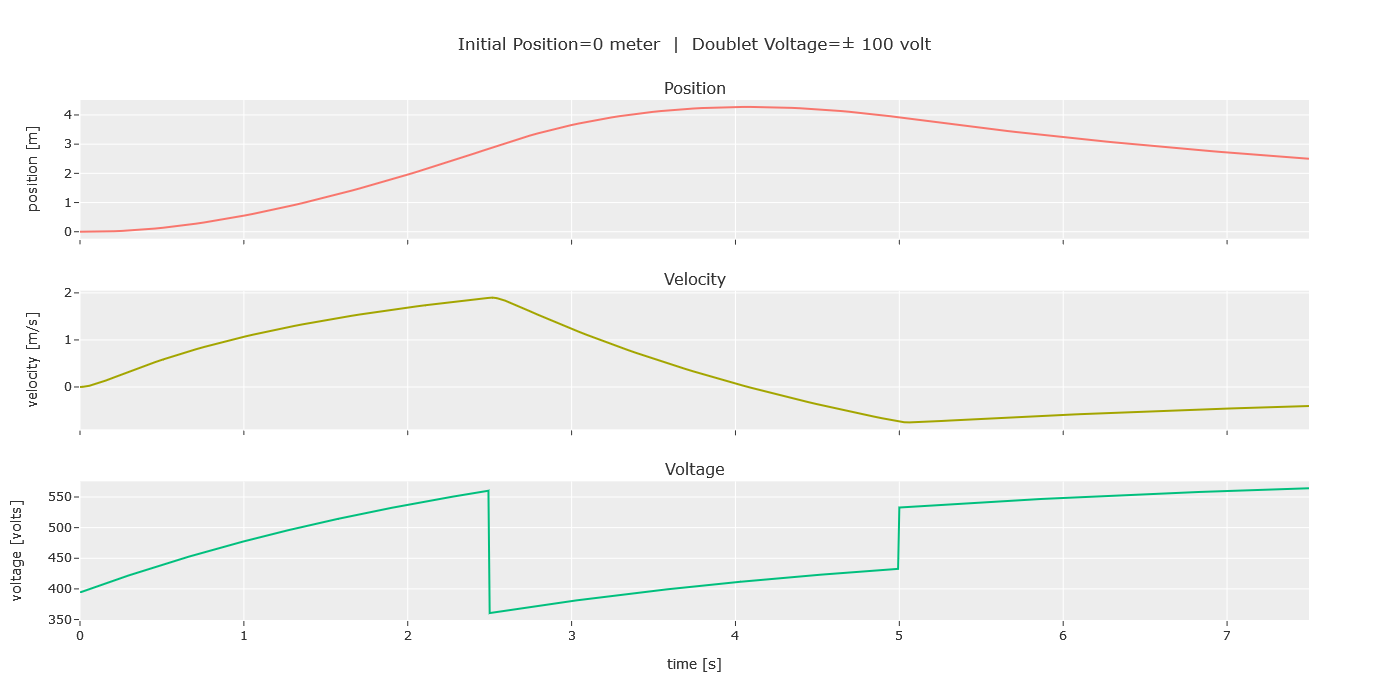

In [32]:
nonlinear_analysis(0, doublet_magnitude=100, )

### $x = 15$

+------+---------+--------+------+
| x_0  | x_dot_0 |  i_0   | r_0  |
+------+---------+--------+------+
| 15.0 |   0.0   | 59.615 | 3.04 |
+------+---------+--------+------+


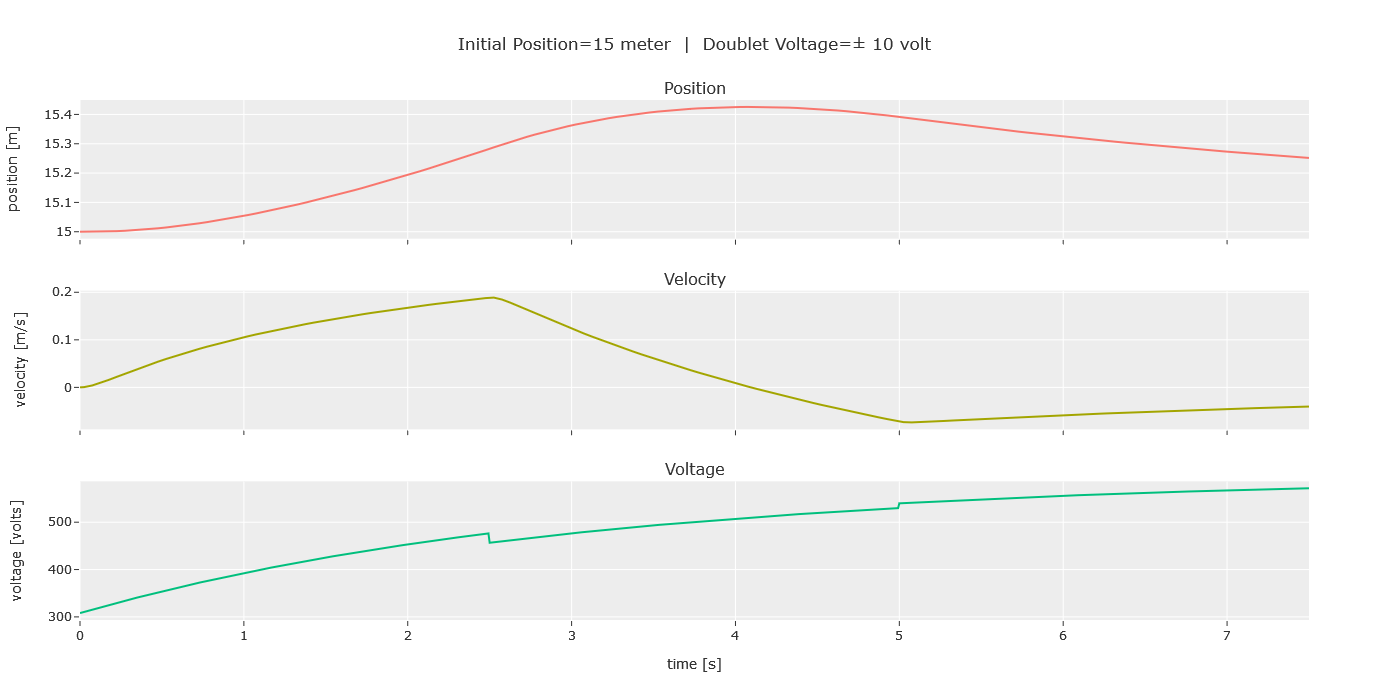

In [33]:
nonlinear_analysis(15, doublet_magnitude=10)

### $x = 30$

+------+---------+--------+-------+
| x_0  | x_dot_0 |  i_0   |  r_0  |
+------+---------+--------+-------+
| 30.0 |   0.0   | 60.381 | 3.079 |
+------+---------+--------+-------+


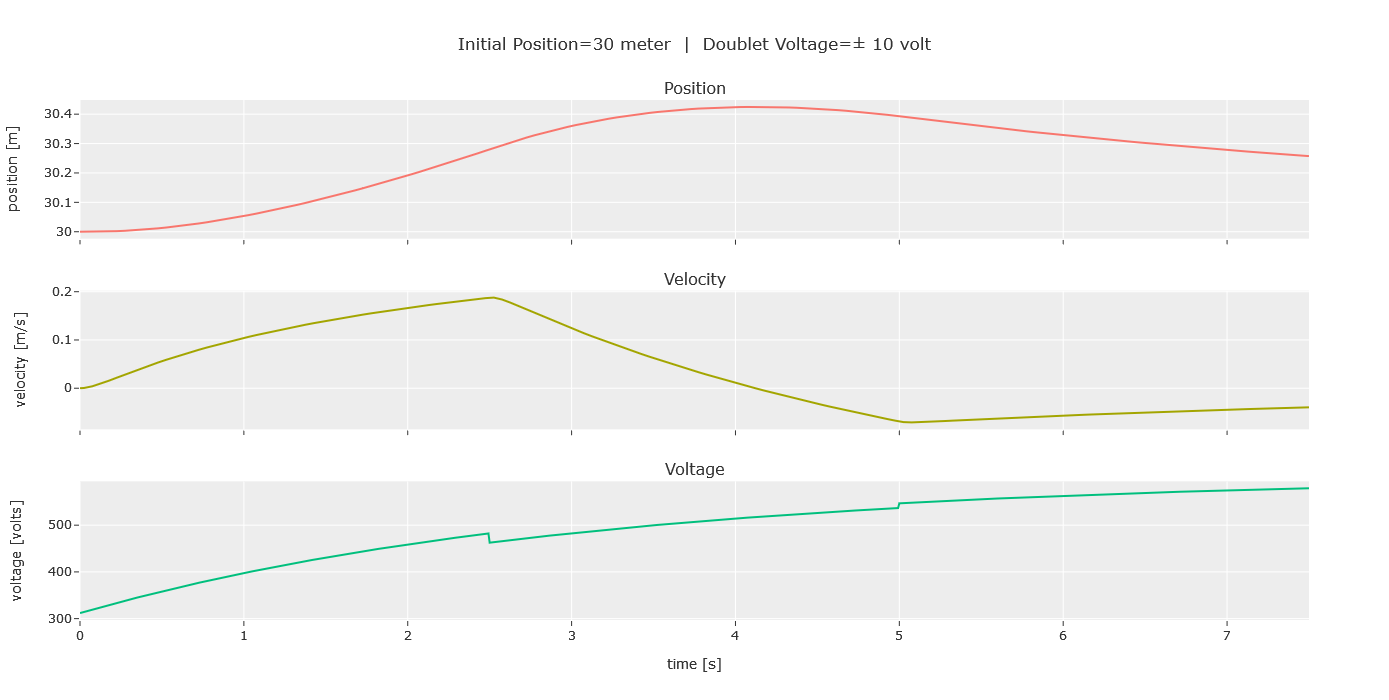

In [34]:
nonlinear_analysis(30, doublet_magnitude=10)

### Far Away from Initial Conditions

In [35]:
x_far = 500
v_far = 1000

+-------+---------+--------+-------+
|  x_0  | x_dot_0 |  i_0   |  r_0  |
+-------+---------+--------+-------+
| 500.0 |   0.0   | 80.767 | 4.118 |
+-------+---------+--------+-------+


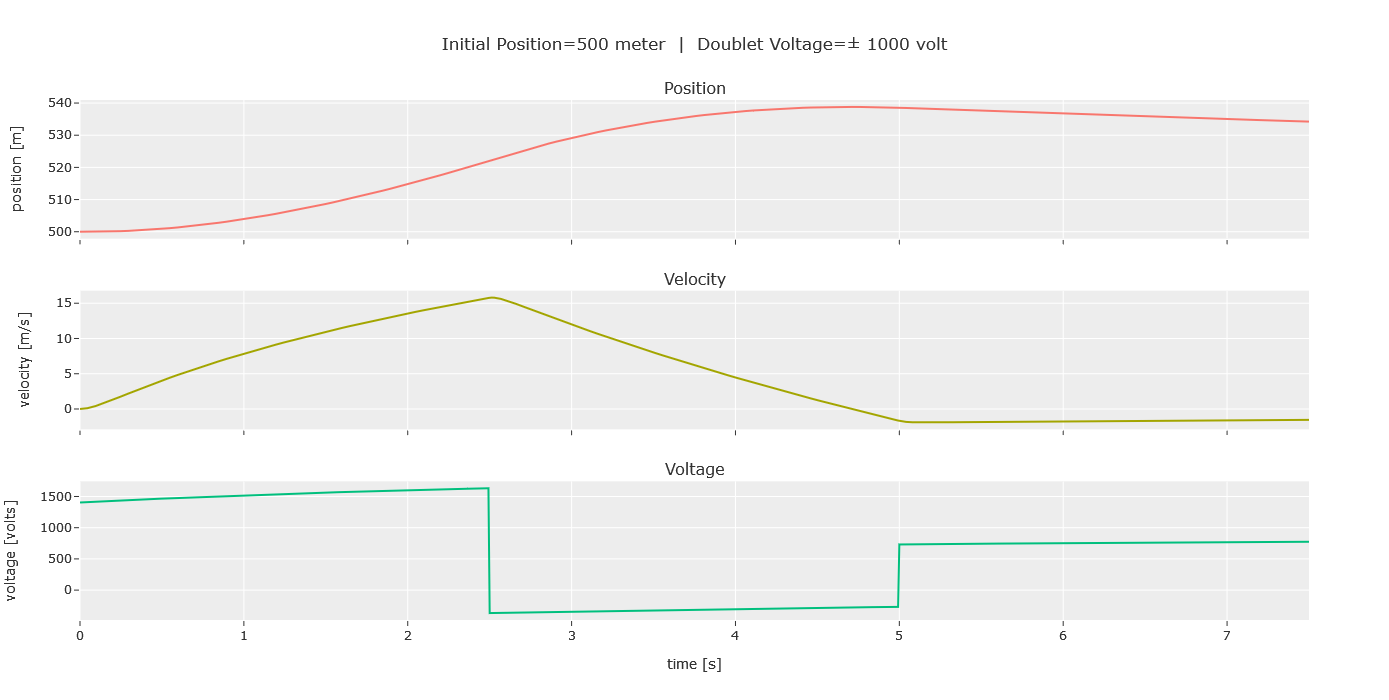

In [36]:
nonlinear_analysis(x_far, doublet_magnitude=v_far)

## Problem 4

Simulate the linearized system with a doublet input for Δ𝑣 for initial conditions close and
far from the three equilibrium points from part 2. Use a doublet magnitude which keep the
elevator velocity reasonable

In [37]:
def linear_analysis(x, doublet_magnitude, method='ivp', i_0: float = 0, ):

    doublet_dt = 5

    # create the time vector
    t = np.linspace(0, doublet_dt / 2 * 3, 1000)

    # create the elevator object
    elevator = LinearElevator(x=x, 
                              doublet_c=doublet_magnitude, 
                              doublet_d_t=doublet_dt)

    x0 = np.array([elevator.x.magnitude, 0, i_0 or elevator.i_bar.magnitude, elevator.r_bar.magnitude])

    pretty_print(x0, headers=['x_0', 'x_dot_0', 'i_0', 'r_0'])

    # solving the scipy StateSpace + lsim way
    if method in 'lsim':
        U = np.asarray(list(elevator.doublet(_t).magnitude for _t in t))
        elevator_ss = StateSpace(
            elevator.A, elevator.B.T, elevator.C, elevator.D.T)
        _, y, s = lsim(elevator_ss, U, t, X0=x0)
        pos = [_y[0] for _y in y]
        v = [_y[1] for _y in y]
        t_ode = t

    else:
        # solving with solve_ivp
        s = elevator.solve_ivp(x0=x0, t_low=t[0], t_high=t[-1])
        pos = s.y[0]
        v = s.y[1]
        t_ode = s.t

    # plotting the results
    fig = make_subplots(rows=3, cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.1,
                        subplot_titles=("Position", "Velocity", "Voltage"))

    fig.add_trace(go.Scatter(x=t_ode, y=pos), row=1, col=1)
    fig.add_trace(go.Scatter(x=t_ode, y=v), row=2, col=1)
    fig.add_trace(go.Scatter(x=t_ode, y=[elevator.doublet(_t).magnitude for _t in t_ode]), row=3, col=1)

    fig.update_layout(
        showlegend=False,
        title=f"Initial Position={round(elevator.x, 1)}  |  Voltage={round(elevator.v_bar, 2)} ± {round(elevator.doublet_c, 2)}",
        height=700,
        width=1000,
        xaxis3=dict(title="time [s]"),
        yaxis=dict(title='position [m]'),
        yaxis2=dict(title='velocity [m/s]'),
        yaxis3=dict(title='voltage [volts]')
    )

    fig.show()


### Position $x = 0$

+-----+---------+-------+-----+
| x_0 | x_dot_0 |  i_0  | r_0 |
+-----+---------+-------+-----+
| 0.0 |   0.0   | 58.84 | 3.0 |
+-----+---------+-------+-----+


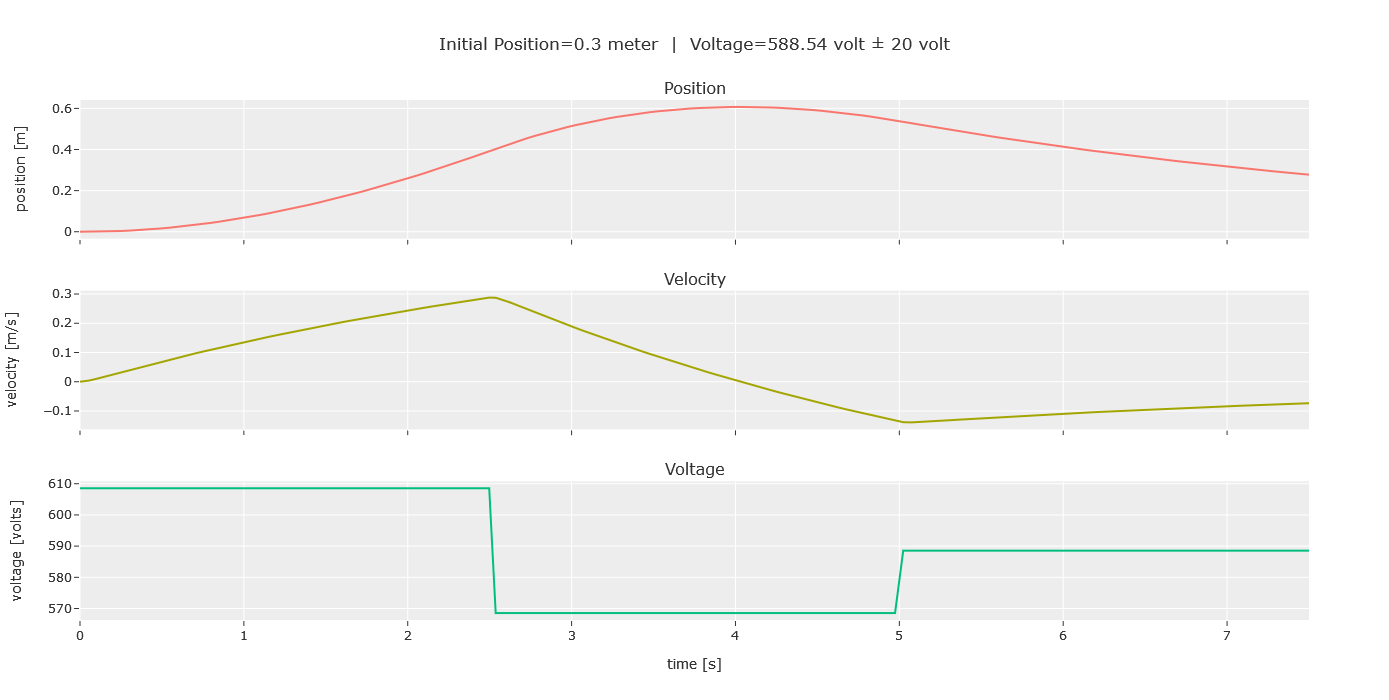

In [38]:
x = 0
linear_analysis(x, doublet_magnitude=20, )

### Position $x = 15$

+------+---------+--------+------+
| x_0  | x_dot_0 |  i_0   | r_0  |
+------+---------+--------+------+
| 15.0 |   0.0   | 59.615 | 3.04 |
+------+---------+--------+------+


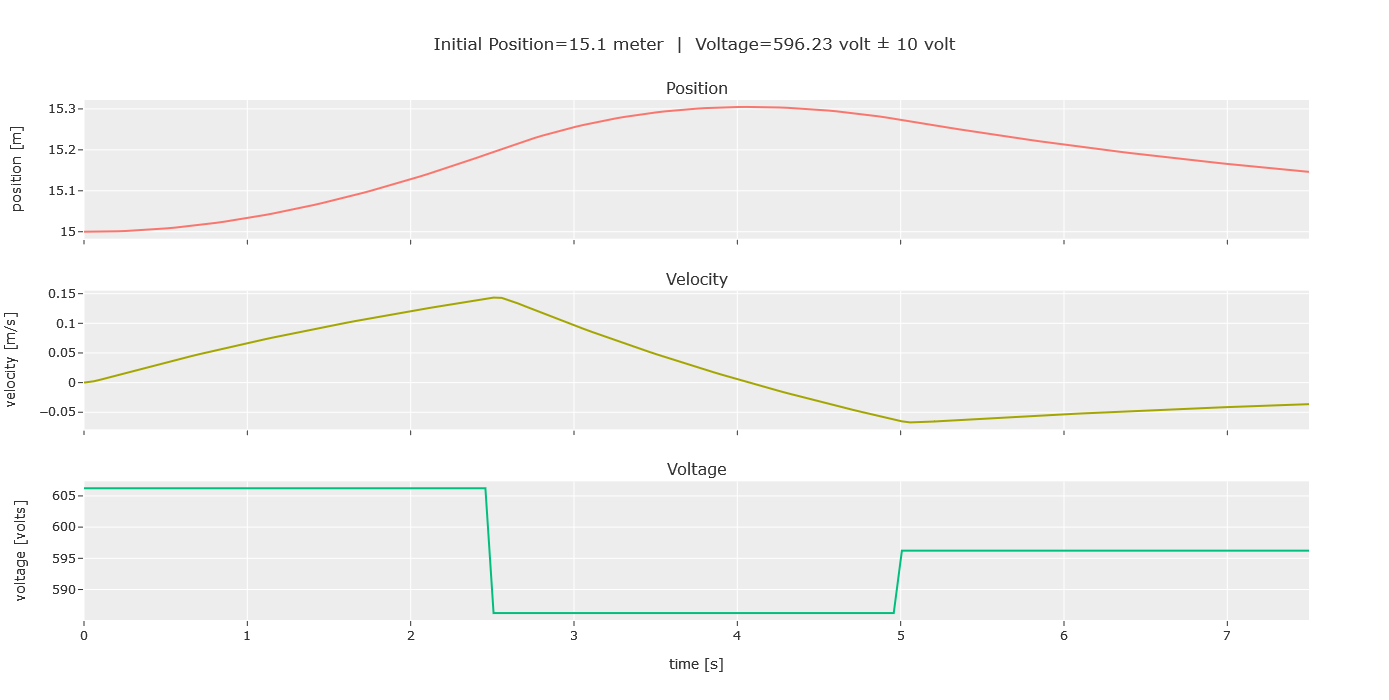

In [39]:
x = 15
linear_analysis(x, doublet_magnitude=10)

### Position $x = 30$

+------+---------+--------+-------+
| x_0  | x_dot_0 |  i_0   |  r_0  |
+------+---------+--------+-------+
| 30.0 |   0.0   | 60.381 | 3.079 |
+------+---------+--------+-------+


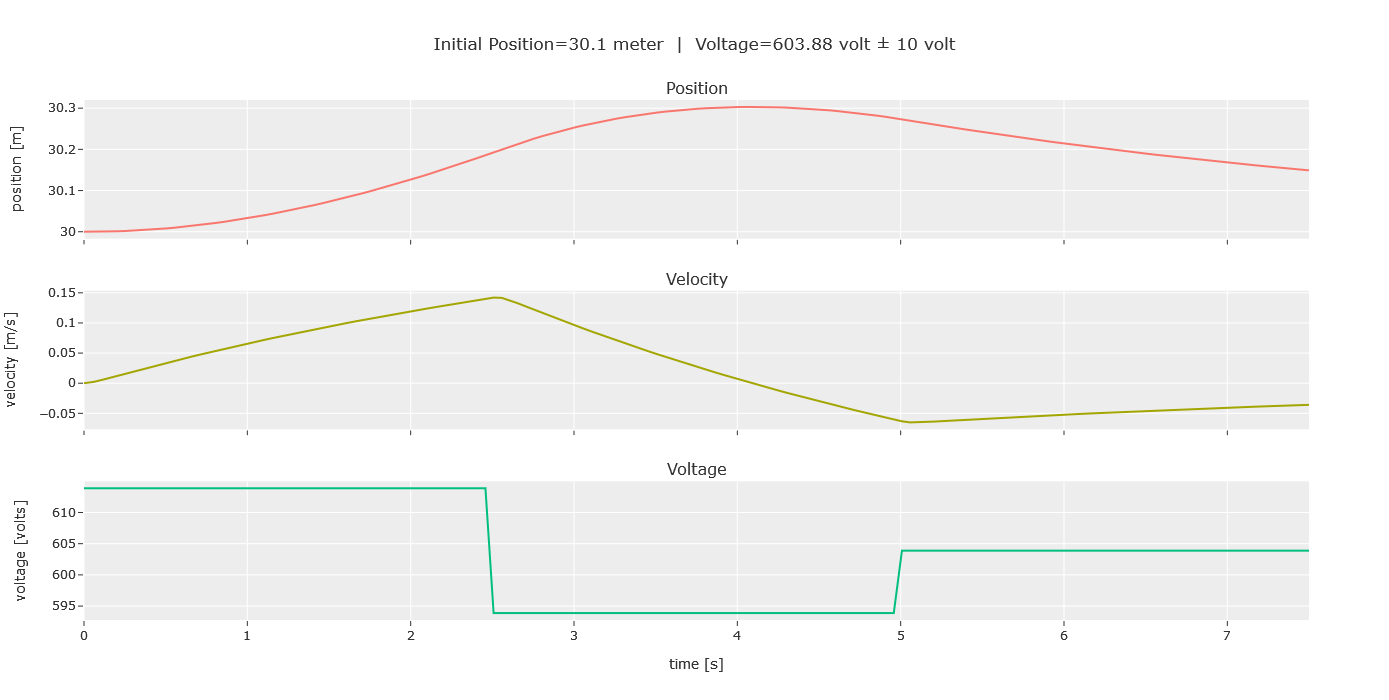

In [40]:
x = 30
linear_analysis(x, doublet_magnitude=10)

### Far Away from Initial Conditions  

+-------+---------+--------+-------+
|  x_0  | x_dot_0 |  i_0   |  r_0  |
+-------+---------+--------+-------+
| 500.0 |   0.0   | 80.767 | 4.118 |
+-------+---------+--------+-------+


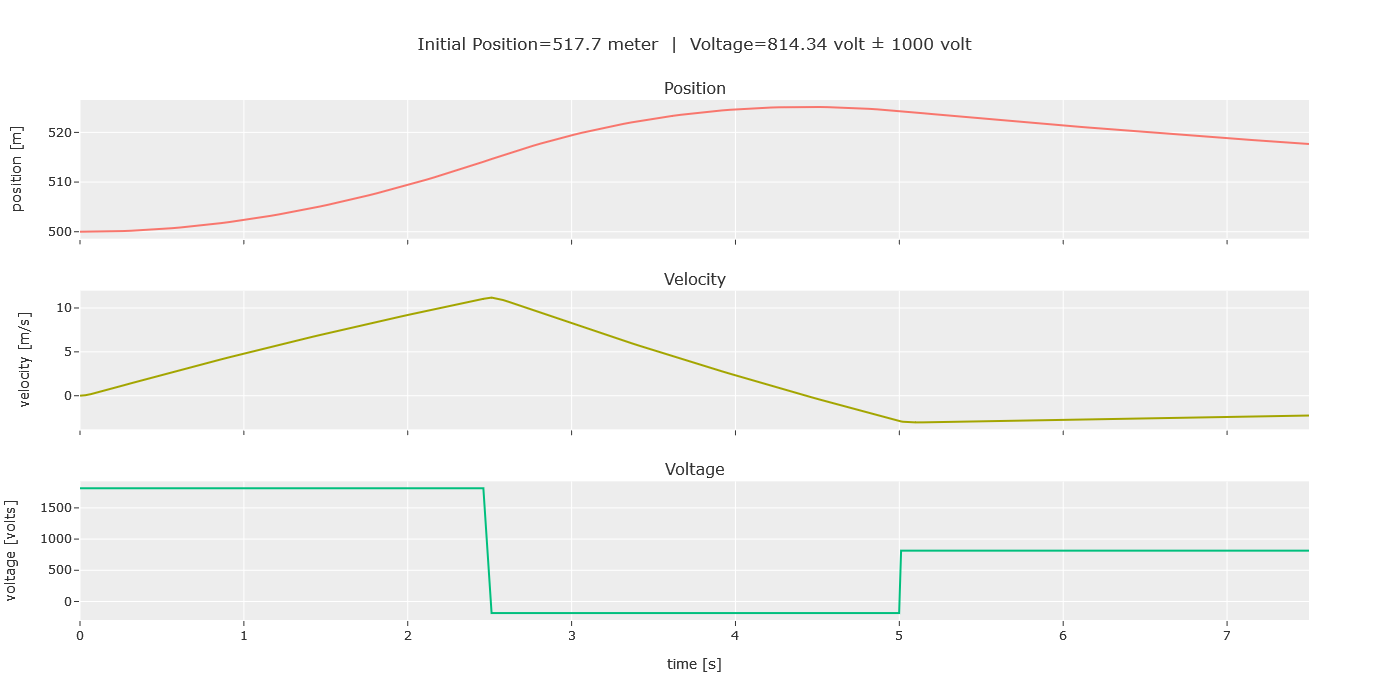

In [41]:
linear_analysis(x_far, doublet_magnitude=v_far)

## Problem 5

Write a few paragraphs summarizing the results of these simulations and any analysis. Make sure to compare the linear simulations to the nonlinear.

### Plotting the Linear and Non-Linear Elevators Together

In [42]:
x = 100
doublet_magnitude = 200
doublet_dt = 10

# create the time vector
t = np.linspace(0, doublet_dt / 2 * 3, 1000)

# create the elevator objects
l_elevator = LinearElevator(x=x, doublet_c=doublet_magnitude, doublet_d_t=doublet_dt)
nl_elevator = NonLinearElevator(x, doublet_c=doublet_magnitude, doublet_d_t=doublet_dt)
nld_elevator = deepcopy(nl_elevator)

# Solving each of the situations
x0 = np.array([l_elevator.x.magnitude, 0, l_elevator.i_bar.magnitude, l_elevator.r_bar.magnitude])

# why wait 3x as long! 
# Nevermind stupid ipynb kernel doesn't support inlme mp
# from multiprocessing import Pool
# import functools

# def p_map(i, f, **kwargs):
    
#     print(i, f)

#     return i, f(**kwargs)

# with Pool(processes=3) as pool:
#     results = pool.starmap(
#         p_map, [
#             (1, l_elevator.solve_ivp, dict(x0=x0, t_low=t[0], t_high=t[-1])),
#             (2, nl_elevator.solve_ivp, dict(x0=x0, t_low=t[0], t_high=t[-1])),
#             (3, nld_elevator.solve_ivp, dict(x0=x0, t_low=t[0], t_high=t[-1], dynamic_doublet=False)), 
#         ]
#     )
# l_s, nl_s, nl_sd = (x[1] for x in sorted(results, lambda x: x[0]))

l_s = l_elevator.solve_ivp(x0=x0, t_low=t[0], t_high=t[-1])
nl_s = nl_elevator.solve_ivp(x0=x0, t_low=t[0], t_high=t[-1])
nl_sd = nld_elevator.solve_ivp(x0=x0, t_low=t[0], t_high=t[-1], dynamic_doublet=False)



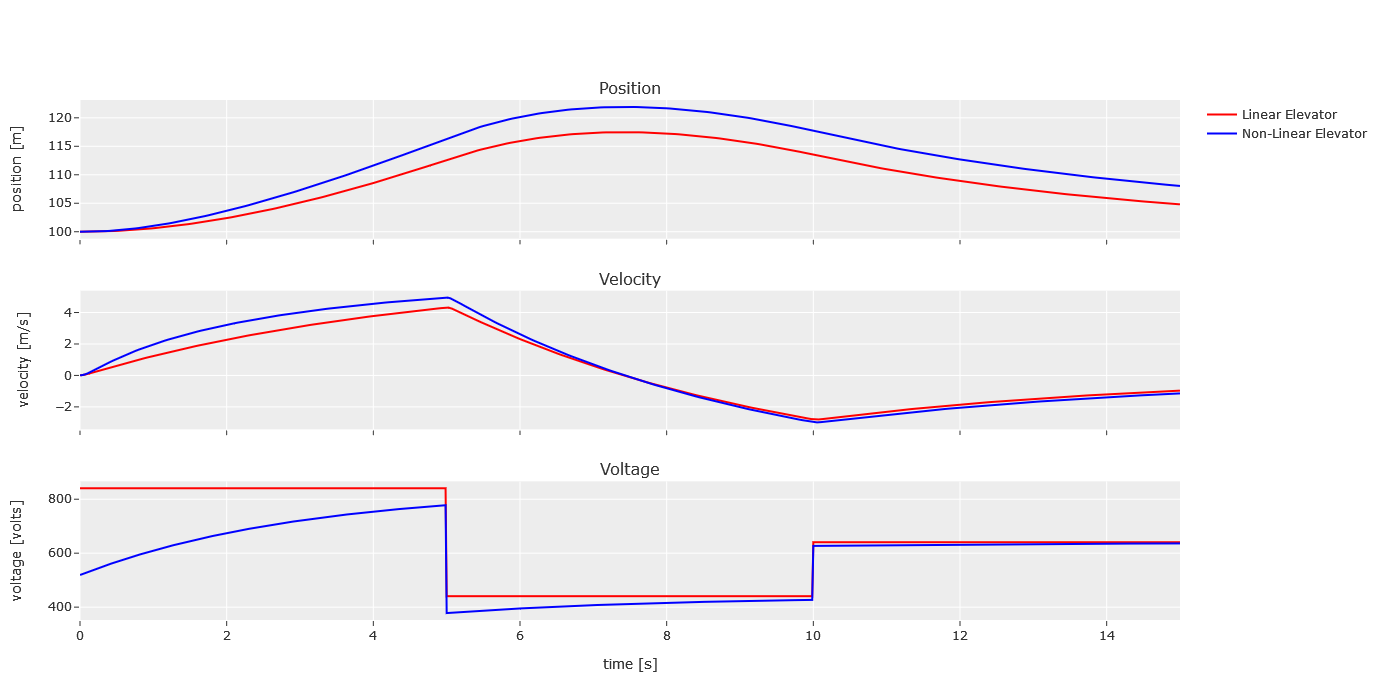

In [43]:

fig = make_subplots(rows=3, cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.1,
                        subplot_titles=("Position", "Velocity", "Voltage"))

fig.add_trace(go.Scatter(x=l_s.t, y=l_s.y[0], line=dict(color='red'), name="Linear Elevator"), row=1, col=1)
fig.add_trace(go.Scatter(x=l_s.t, y=l_s.y[1], line=dict(color='red'), showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=t, y=[l_elevator.doublet(_t, ).magnitude for _t in t], line=dict(color='red'), showlegend=False), row=3, col=1)

fig.add_trace(go.Scatter(x=nl_s.t, y=nl_s.y[0], line=dict(color='blue'), name="Non-Linear Elevator"), row=1, col=1)
fig.add_trace(go.Scatter(x=nl_s.t, y=nl_s.y[1], line=dict(color='blue'), showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=t, y=[nl_elevator.doublet(_t, ).magnitude for _t in t], line=dict(color='blue'), showlegend=False), row=3, col=1)

# fig.add_trace(go.Scatter(x=nl_sd.t, y=nl_sd.y[0], line=dict(color='green'), name="Non-Linear Elevator - Static Doublet"), row=1, col=1)
# fig.add_trace(go.Scatter(x=nl_sd.t, y=nl_sd.y[1], line=dict(color='green'), showlegend=False), row=2, col=1)
# fig.add_trace(go.Scatter(x=t, y=[nl_elevator.doublet(_t, False).magnitude for _t in t], line=dict(color='green'), showlegend=False), row=3, col=1)



fig.update_layout(
    # showlegend=False,
    # title=f"Initial Position={round(elevator.x, 1)}  |  Voltage={round(elevator.v_bar, 2)} ± {round(elevator.doublet_c, 2)}",
    height=700,
    width=1000,
    xaxis3=dict(title="time [s]"),
    yaxis=dict(title='position [m]'),
    yaxis2=dict(title='velocity [m/s]'),
    yaxis3=dict(title='voltage [volts]')
)

fig.show()

### Plotting Linear v Non-Linear with Initial Velocity

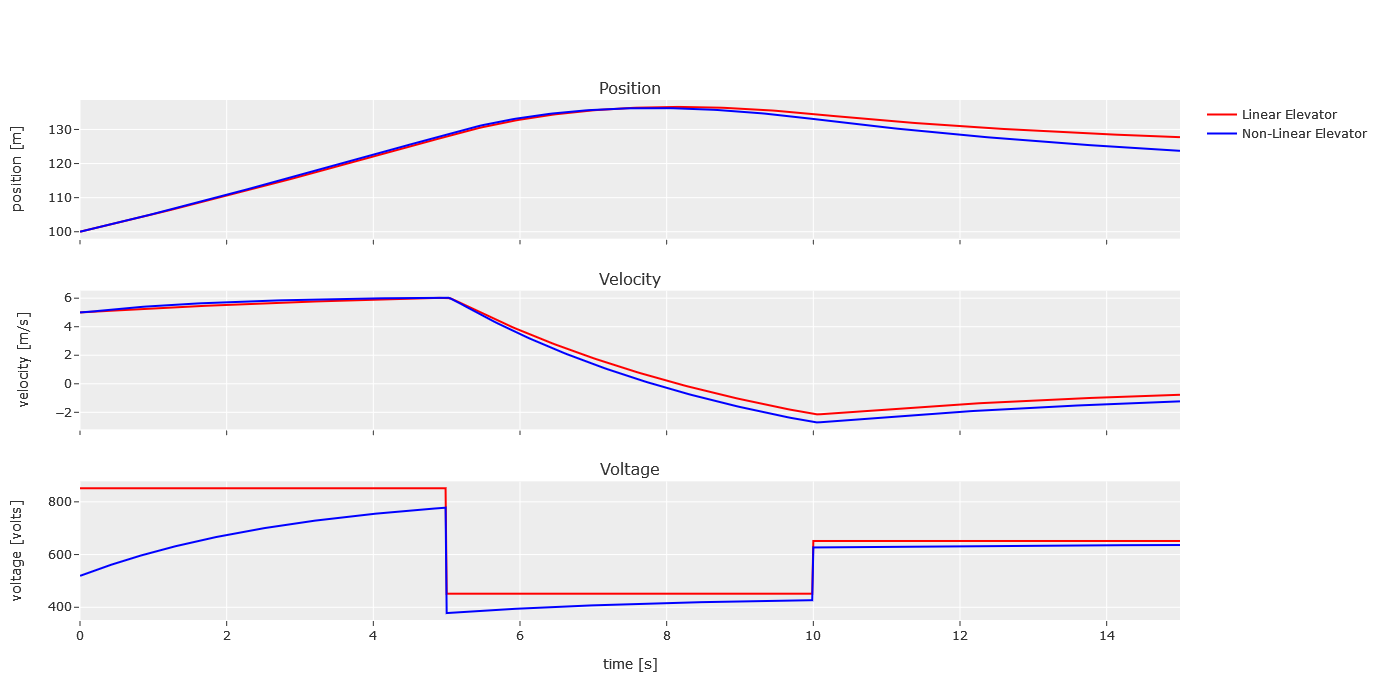

In [45]:
x = 100
velocity_0 = 5 # m/s
doublet_magnitude = 200
doublet_dt = 10

# create the time vector
t = np.linspace(0, doublet_dt / 2 * 3, 1000)

# create the elevator objects
l_elevator = LinearElevator(x=x, doublet_c=doublet_magnitude, doublet_d_t=doublet_dt)
nl_elevator = NonLinearElevator(x, doublet_c=doublet_magnitude, doublet_d_t=doublet_dt)

# Solving each of the situations
x0 = np.array([l_elevator.x.magnitude, velocity_0, l_elevator.i_bar.magnitude, l_elevator.r_bar.magnitude])

l_s = l_elevator.solve_ivp(x0=x0, t_low=t[0], t_high=t[-1])
nl_s = nl_elevator.solve_ivp(x0=x0, t_low=t[0], t_high=t[-1])

fig = make_subplots(rows=3, cols=1,
                        shared_xaxes=True,
                        vertical_spacing=0.1,
                        subplot_titles=("Position", "Velocity", "Voltage"))

fig.add_trace(go.Scatter(x=l_s.t, y=l_s.y[0], line=dict(color='red'), name="Linear Elevator"), row=1, col=1)
fig.add_trace(go.Scatter(x=l_s.t, y=l_s.y[1], line=dict(color='red'), showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=t, y=[l_elevator.doublet(_t, ).magnitude for _t in t], line=dict(color='red'), showlegend=False), row=3, col=1)

fig.add_trace(go.Scatter(x=nl_s.t, y=nl_s.y[0], line=dict(color='blue'), name="Non-Linear Elevator"), row=1, col=1)
fig.add_trace(go.Scatter(x=nl_s.t, y=nl_s.y[1], line=dict(color='blue'), showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=t, y=[nl_elevator.doublet(_t, ).magnitude for _t in t], line=dict(color='blue'), showlegend=False), row=3, col=1)

fig.update_layout(
    # showlegend=False,
    # title=f"Initial Position={round(elevator.x, 1)}  |  Voltage={round(elevator.v_bar, 2)} ± {round(elevator.doublet_c, 2)}",
    height=700,
    width=1000,
    xaxis3=dict(title="time [s]"),
    yaxis=dict(title='position [m]'),
    yaxis2=dict(title='velocity [m/s]'),
    yaxis3=dict(title='voltage [volts]')
)

fig.show()


### Written Explanation


This project explored the effects of linearizing a non-linear system, which can best be visualized by the plot above. To linearize, two assumptions were made: 
1. The resistance of the motor was assumed to be the resistance as $t \rightarrow \infty$
2. $\dot{v}$ was assumed to be zero

Making these assumptions removed _some_ of the influence of the motor momentum, as well as the motor back EMF. Using the linearized system as an approximation suffices at points near the equilibrium points, but seems to break down as the acceleration increases. Because the elevator typically operates in low acceleration regions, this approximation is appropriate. To design a control system, one must consider that the linear representation is unstable due to negative real eigenvalues. The rank of the controllability matrix $\mathbf{R}$ is also 3, which is less than $n$, so the Linear system is not completely controllable.    

It also should be noted that solving the linear system with `scipy.signal.StateSpace` + `scipy.signal.lsim` is order of magnitudes faster than using `solve_ivp` on the non-linear system.  